# S2S Haiti - Zonal statistics

Zonal statistics are run on the standardized [H3 grid](https://h3geo.org/docs/core-library/restable/); the process is run on a country-by-country basis.

For the zonal statistics, each zonal statistic is run against the source dataset as a whole, then it is stratified by urban classification from the European Commission - [GHS-SMOD](https://ghsl.jrc.ec.europa.eu/ghs_smod2019.php). This creates an summary dataset that has the standard zonal stats columns (SUM, MEAN, MAX, MIN) as well as the same for urban areas (SUM_urban, MEAN_urban, MAX_urban, MIN_urban).

In [1]:
import sys, os, importlib, math, multiprocessing
import rasterio, geojson

import pandas as pd
import geopandas as gpd
import numpy as np

from h3 import h3
from tqdm import tqdm
from shapely.geometry import Polygon

sys.path.insert(0, "/home/wb411133/Code/gostrocks/src")
import GOSTRocks.rasterMisc as rMisc
import GOSTRocks.ntlMisc as ntl
import GOSTRocks.mapMisc as mapMisc
from GOSTRocks.misc import tPrint

sys.path.append("../src")
import h3_helper
import country_zonal

%load_ext autoreload
%autoreload 2

In [2]:
sel_iso3 = "HTI"
h3_level = 6

admin_bounds = "/home/public/Data/GLOBAL/ADMIN/ADMIN2/HighRes_20230328/shp/WB_GAD_ADM2.shp"
out_folder = f"/home/wb411133/projects/Space2Stats/{sel_iso3}"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
global_urban = "/home/public/Data/GLOBAL/GHSL/SMOD/GHS_SMOD_E2020_GLOBE_R2023A_54009_1000_V1_0.tif"

In [3]:
inA = gpd.read_file(admin_bounds)
selA = inA.loc[inA['ISO_A3'] == sel_iso3].copy()
selA['ID'] = selA.index #Create ID for indexing

inU = rasterio.open(global_urban)

In [4]:
# As a demo, we will begin with nighttime lights layers
ntl_layers = ntl.aws_search_ntl()
ntl_file = ntl_layers[-1]

# Generate zonal statistics at h3 based on urbanization levels

In [5]:
def get_per(x):
    try:
        return(x['SUM_urban']/x['SUM'] * 100)
    except:
        return(0)

## Population

In [6]:
global_pop_layer = "/home/public/Data/GLOBAL/GHSL/Pop/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0.tif"

In [7]:
zonalC = country_zonal.country_h3_zonal(sel_iso3, selA, "ID", h3_level, out_folder)
zonal_res_pop = zonalC.zonal_raster_urban(global_pop_layer, global_urban)

100%|██████████| 202/202 [00:01<00:00, 196.99it/s]


In [8]:
map_data_pop = zonal_res_pop.sort_values("SUM_urban").loc[:,['shape_id','SUM','SUM_urban']].copy()
map_data_pop = pd.merge(zonalC.h3_cells, map_data_pop, on='shape_id')
map_data_pop['per_urban'] = map_data_pop.apply(get_per, axis=1)
map_data_pop.sort_values('SUM')

,index,geometry,shape_id,index_right,ID,SUM,SUM_urban,per_urban
21,864c8a817ffffff,"POLYGON ((-72.75291 20.09093, -72.77929 20.077...",864c8a817ffffff,36452,36452,-238.286994,0.0,-0.000000
73,864c8ad4fffffff,"POLYGON ((-72.92188 20.09102, -72.94830 20.077...",864c8ad4fffffff,36452,36452,-229.921339,60.0,-26.095881
13,864c8a8a7ffffff,"POLYGON ((-72.80921 20.09098, -72.83560 20.077...",864c8a8a7ffffff,36452,36452,-128.124768,413.0,-322.342048
602,8667258a7ffffff,"POLYGON ((-72.03023 18.64439, -72.05657 18.630...",8667258a7ffffff,36503,36503,0.000000,0.0,0.000000
693,8667258afffffff,"POLYGON ((-71.99667 18.60254, -72.02300 18.588...",8667258afffffff,36493,36493,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...
679,866725c1fffffff,"POLYGON ((-72.33478 18.60207, -72.36120 18.588...",866725c1fffffff,36488,36488,223787.948762,222807.0,99.561661
486,864c88687ffffff,"POLYGON ((-72.20424 19.76281, -72.23052 19.749...",864c88687ffffff,36418,36418,233049.883958,231887.0,99.501015
528,866725c8fffffff,"POLYGON ((-72.41407 18.55991, -72.44051 18.545...",866725c8fffffff,36487,36487,236411.146463,234849.0,99.339225
105,866725ce7ffffff,"POLYGON ((-72.30118 18.56020, -72.32759 18.546...",866725ce7ffffff,36501,36501,320978.277533,319626.0,99.578701


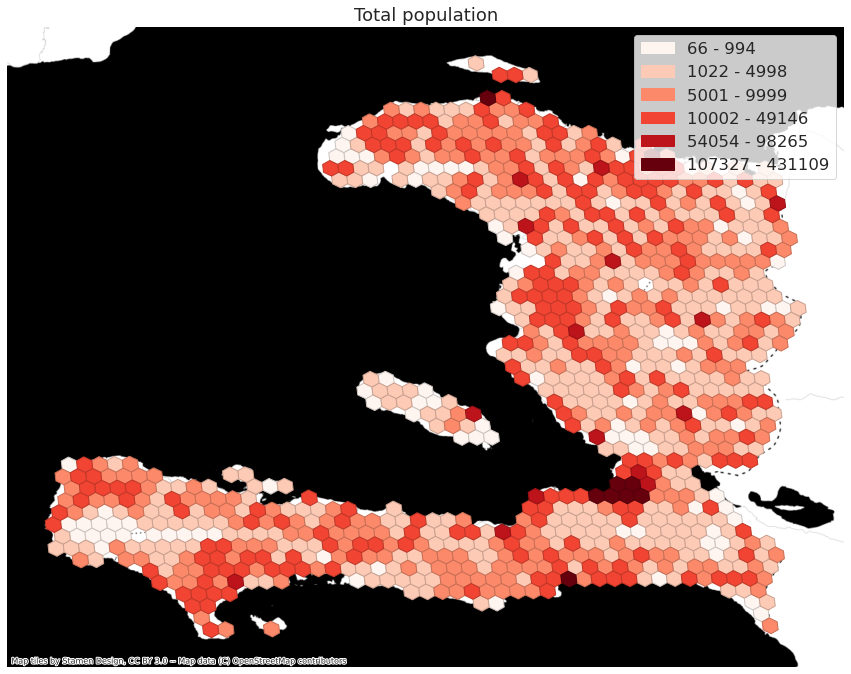

In [9]:
map_plt = mapMisc.static_map_vector(map_data_pop, "SUM", thresh=[50, 1000, 5000, 10000, 50000, 100000, 500000, 1500000], figsize=(15, 15))
map_plt.title("Total population")
map_plt.show()

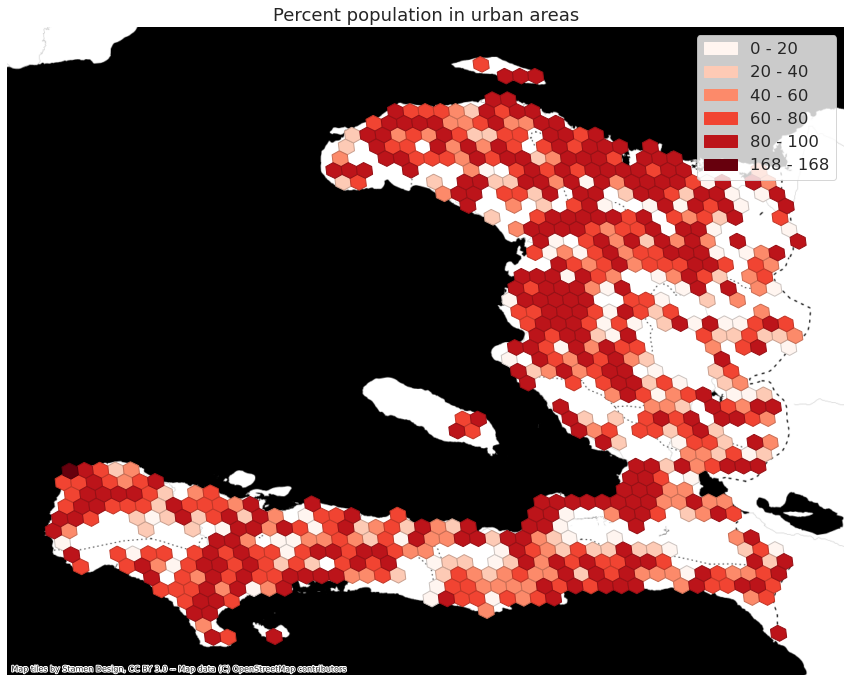

In [10]:
map_plt = mapMisc.static_map_vector(map_data_pop, "per_urban", thresh=[0, 20, 40, 60, 80, 100, 1000], figsize=(15,15))
map_plt.title("Percent population in urban areas")
map_plt.show()

## Nighttime Lights

In [11]:
zonalC = country_zonal.country_h3_zonal(sel_iso3, selA, "ID", h3_level, out_folder)
zonal_res = zonalC.zonal_raster_urban(ntl_file, global_urban)

100%|██████████| 202/202 [00:01<00:00, 198.70it/s]


In [12]:
map_data = zonal_res.sort_values("SUM_urban").loc[:,['shape_id','SUM','SUM_urban']].copy()
map_data = pd.merge(zonalC.h3_cells, map_data, on='shape_id')
map_data['per_urban'] = map_data.apply(get_per, axis=1)
map_data.sort_values('SUM')

,index,geometry,shape_id,index_right,ID,SUM,SUM_urban,per_urban
339,866725157ffffff,"POLYGON ((-71.99766 18.39270, -72.02401 18.378...",866725157ffffff,36490,36490,38.020000,0.0,0.000000
718,86672515fffffff,"POLYGON ((-71.96406 18.35068, -71.99041 18.336...",86672515fffffff,36492,36492,38.529999,0.0,0.000000
98,86672514fffffff,"POLYGON ((-71.90776 18.35075, -71.93409 18.336...",86672514fffffff,36492,36492,38.549999,0.0,0.000000
345,866725027ffffff,"POLYGON ((-72.05399 18.39262, -72.08036 18.378...",866725027ffffff,36490,36490,38.550003,0.0,0.000000
168,8667250a7ffffff,"POLYGON ((-72.18953 18.35026, -72.21594 18.336...",8667250a7ffffff,36476,36476,38.949997,0.0,0.000000
...,...,...,...,...,...,...,...,...
946,864c8b977ffffff,"POLYGON ((-71.73426 19.59698, -71.76043 19.583...",864c8b977ffffff,36440,36440,359.739990,256.0,71.162508
186,866725cf7ffffff,"POLYGON ((-72.35761 18.56006, -72.38404 18.546...",866725cf7ffffff,36501,36501,635.240051,554.0,87.211126
386,866725c0fffffff,"POLYGON ((-72.27837 18.60219, -72.30477 18.588...",866725c0fffffff,36502,36502,740.360046,673.0,90.901718
105,866725ce7ffffff,"POLYGON ((-72.30118 18.56020, -72.32759 18.546...",866725ce7ffffff,36501,36501,817.319946,750.0,91.763330


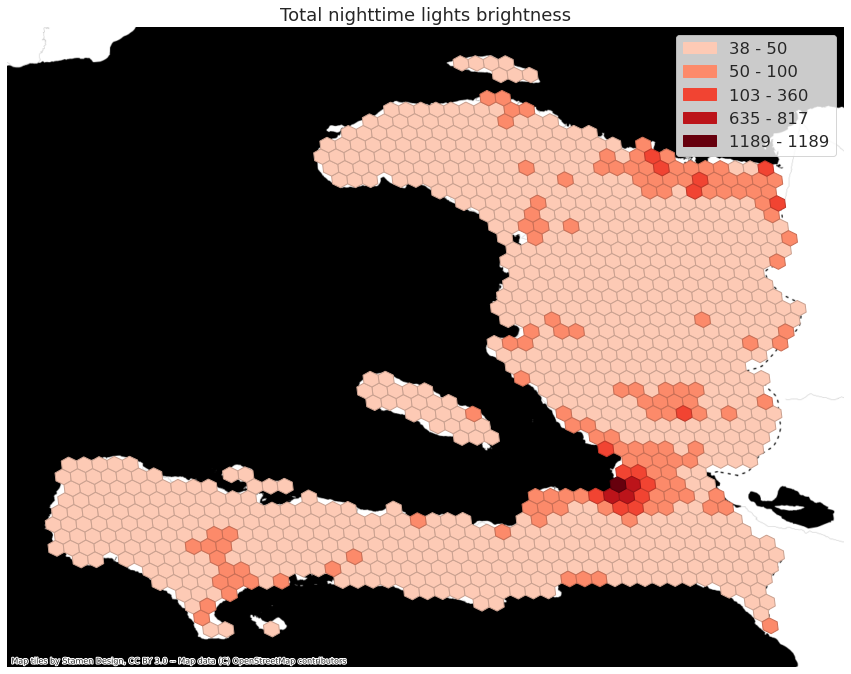

In [13]:
map_plt = mapMisc.static_map_vector(map_data, "SUM", thresh=[5,10,50,100,500,1000,7000], figsize=(15,15))
map_plt.title("Total nighttime lights brightness")
map_plt.show()

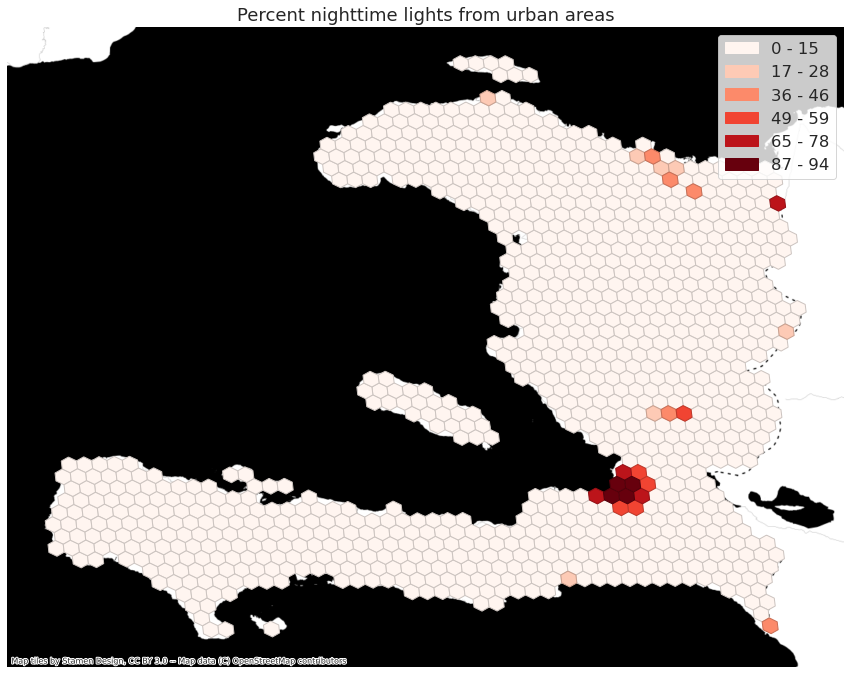

In [14]:
map_plt = mapMisc.static_map_vector(map_data, "per_urban", figsize=(15,15))
map_plt.title("Percent nighttime lights from urban areas")
map_plt.show()

# Join h3 zonal results to admin boundaries

below we compare timing the administrative summaries with and without fractional intersections. While there is a difference between the two, the overall process is quite fast. As the is no computational limitation, we will rely on the fractional intersection as it is more accurate.

In [15]:
### These two cells are used to test the speed of joining with and without
# %timeit cur_res = country_zonal.connect_polygons_h3_stats(selA, zonal_res, h3_level, "ID", True)

In [16]:
# %timeit cur_res = country_zonal.connect_polygons_h3_stats(selA, zonal_res, h3_level, "ID", False)

In [17]:
cur_res = country_zonal.connect_polygons_h3_stats(selA, zonal_res_pop, h3_level, "ID", True)

In [18]:
map_admin = pd.merge(selA, cur_res, left_on="ID", right_on='id')
map_admin['per_urban'] = map_admin.apply(get_per, axis=1)

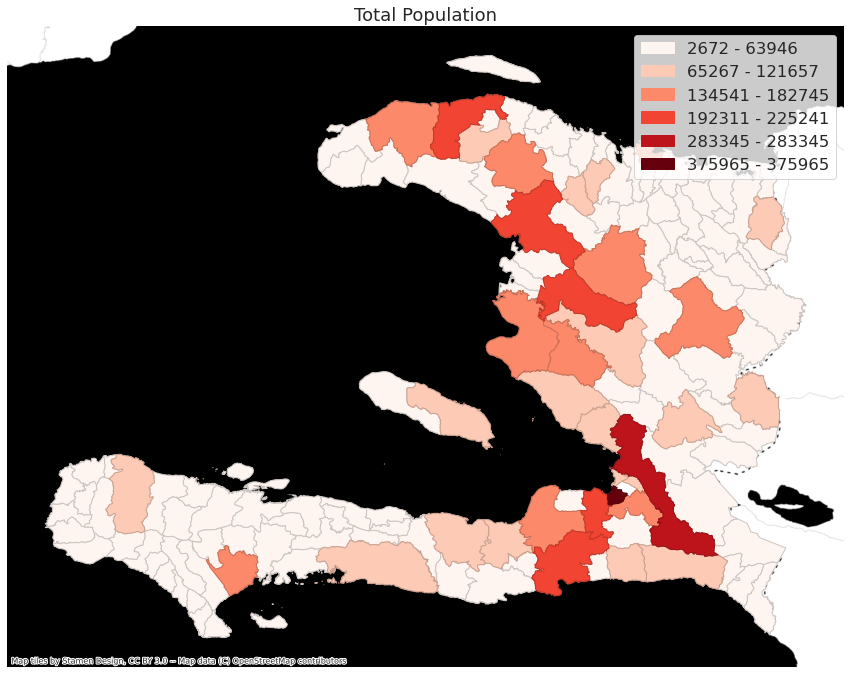

In [19]:
map_plt = mapMisc.static_map_vector(map_admin, "SUM", figsize=(15,15))
map_plt.title("Total Population")
map_plt.show()

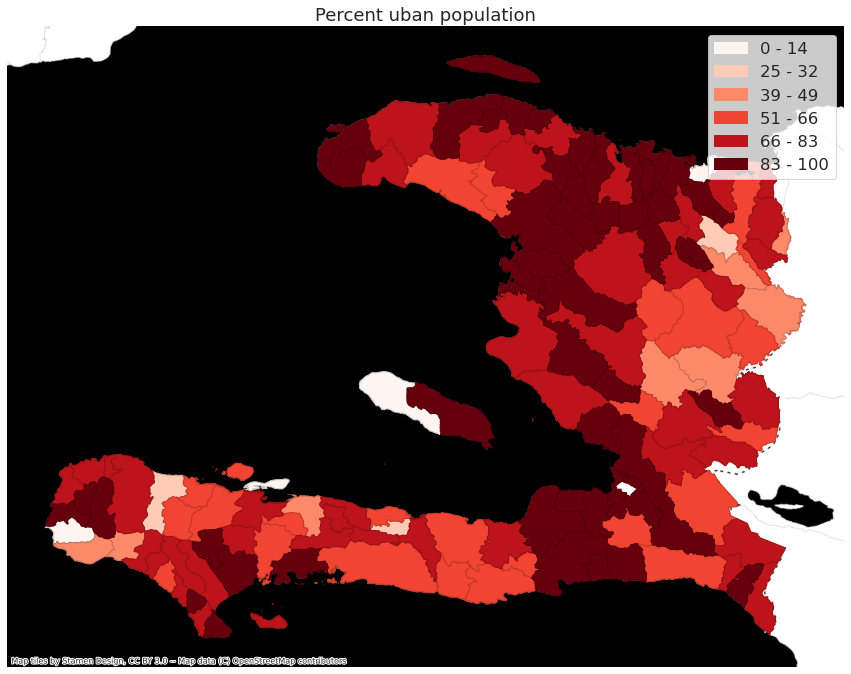

In [20]:
map_plt = mapMisc.static_map_vector(map_admin, "per_urban", figsize=(15,15))
map_plt.title("Percent uban population")
map_plt.show()

# Write output

In [25]:
map_data_pop.to_file(os.path.join(out_folder, "h3_urban_pop.geojson"), driver="GeoJSON")